### Alter the following parameters to provide different graphs below

In [36]:
tests_dir = "../tests/"
# test_dir = tests_dir + "test_1_8_11_2021/" # change this to the folder you want displayed
test_dir = tests_dir + "test_21_12_2021/"
frequency = 30 # frequency of GPS positions (30 = every 30s)


In [37]:
import json

def get_meta(test_dir):
  with open(test_dir + 'meta.json', 'r') as f:
    return json.load(f)

meta = get_meta(test_dir)

start_time = meta["start_time"]
end_time = meta["end_time"] # using a time greater than 10 breaks comparison
using_mesh = meta["using_mesh"]

In [38]:
from os import listdir
from os.path import isfile, join

# get all servant drifter files
def get_file_name_list(test_dir):
    return [test_dir + f for f in listdir(test_dir) if isfile(join(test_dir, f)) and f != "masterD.csv" and f != "meta.json"]

file_name_list = get_file_name_list(test_dir)

# get names of drifters from file names
def get_drifter_names(file_name_list):
    idxOfName = file_name_list[0].index('D')
    return [n[idxOfName : idxOfName + 3] for n in file_name_list]

drifter_names = get_drifter_names(file_name_list)

### Importing Data

In [27]:
import os, csv
import matplotlib.pyplot as plt
import pandas as pd

In [28]:
def read_from_CSV(file_name, frequency, start_time, end_time):
  data = []
  with open(file_name, 'r', newline='') as csvfile:
    csv_reader = csv.reader(csvfile,quoting=csv.QUOTE_ALL)
    for idx, row in enumerate(csv_reader):
      if len(row) == 0:
        continue
      else:
        if '#FILE ERASED AT' not in row:
          if idx != 0:
            if idx % frequency == 0:
              if row[1] > start_time and row[1] < end_time:
                if len(row) == 16:
                  row.pop()
                data.append(row)
    csvfile.close()
    return data

In [29]:
def make_drifter_list(file_name_list, frequency, start_time, end_time, using_mesh=False):
  drifter_list = [None] * 2
  for idx, file_name in enumerate(file_name_list):
    data = read_from_CSV(file_name, frequency, start_time, end_time)
    if not using_mesh:
      drifter_list[idx] = pd.DataFrame(data, columns=['Date', 'Time', 'Longitude', 'Latitude', 'GPS Age'])
    else:
      drifter_list[idx] = pd.DataFrame(data, columns=['Date', 'Time', 'Longitude', 'Latitude', 'GPS Age', 'Sent',
      'Received', 'Master','D01', 'D02','D03','D04','D05','D06','D07'])
  for df in drifter_list:
    print(df.head())
  return drifter_list

drifter_list = make_drifter_list(file_name_list, frequency, start_time, end_time, using_mesh)

         Date     Time   Longitude    Latitude GPS Age Sent Received Master  \
0  2021-12-21  8:38:20  115.181168  -33.931823     246   65       97    610   
1  2021-12-21  8:38:50  115.181102  -33.931886     129   67       98    610   
2  2021-12-21  8:39:20  115.181042  -33.931892      27   70      101    630   
3  2021-12-21  8:39:49  115.181156  -33.931859     118   70      103    630   
4  2021-12-21  8:40:21  115.181196  -33.931810      35   75      108    660   

  D01 D02 D03 D04 D05 D06 D07  
0   0   0   0  36   0   0   0  
1   0   0   0  37   0   0   0  
2   0   0   0  38   0   0   0  
3   0   0   0  40   0   0   0  
4   0   0   0  42   0   0   0  
         Date     Time   Longitude    Latitude GPS Age Sent Received Master  \
0  2021-12-21  8:38:31  115.181060  -33.932032     106   62       93    580   
1  2021-12-21   8:39:1  115.181013  -33.931945     272   63       94    580   
2  2021-12-21  8:39:31  115.180982  -33.931925      70   67       97    600   
3  2021-12-21   8

### Calculating local velocities

In [30]:
import math
from datetime import datetime

# Same as TinyGPS library calculation
def get_distance(lat1, lon1, lat2, lon2):
    delta = math.radians(lon1 - lon2)
    sdlong = math.sin(delta)
    cdlong = math.cos(delta)
    lat1 = math.radians(lat1)
    lat2 = math.radians(lat2)
    slat1 = math.sin(lat1)
    clat1 = math.cos(lat1)
    slat2 = math.sin(lat2)
    clat2 = math.cos(lat2)
    delta = (clat1 * slat2) - (slat1 * clat2 * cdlong)
    delta = delta ** 2
    delta += (clat2 * sdlong) ** 2
    delta = math.sqrt(delta)
    denom = (slat1 * slat2) + (clat1 * clat2 * cdlong)
    delta = math.atan2(delta, denom)
    return delta * 6372795

In [31]:
def split_time_from_df(drifter, using_mesh=False):
  drifter_stamps = []
  for ii in range(len(drifter) - 1):
    # print(drifter_stamps)
    date_stamp = drifter.Date[ii]
    if not using_mesh:
      new_date_stamp = date_stamp.split('/')
    else:
      new_date_stamp = date_stamp.split('-')
    timestamp = drifter.Time[ii]
    new_timestamp = timestamp.split(':')
    drifter_stamps.append([*new_date_stamp, *new_timestamp])
  return drifter_stamps

In [32]:
# def calc_overall_local_currents(drifter_list, drifter_names):
#   drifter_stamps = split_time_from_df(drifter_list[0], using_mesh)
#   start_time_stamps = list(map(int, drifter_stamps[0]))
#   end_time_stamps = list(map(int, drifter_stamps[-1]))
#   start_time = datetime(start_time_stamps[2], start_time_stamps[1], start_time_stamps[0], start_time_stamps[3], start_time_stamps[4], start_time_stamps[5])
#   end_time = datetime(end_time_stamps[2], end_time_stamps[1], end_time_stamps[0], end_time_stamps[3], end_time_stamps[4], end_time_stamps[5])
#   time_delta_s = (end_time - start_time).total_seconds()
#   print('Total drift time')
#   print(time_delta_s, 's\n')
#   for idx, drifter in enumerate(drifter_list):
#     lat_1 = float(drifter.Latitude[0])
#     lon_1 = float(drifter.Longitude[0])
#     lat_2 = float(drifter.Latitude[len(drifter) - 1])
#     lon_2 = float(drifter.Longitude[len(drifter) - 1])
  
#     print(drifter_names[idx])
#     dist = get_distance(lat_1, lon_1, lat_2, lon_2)
#     print("Total distance: ", dist, 'm')
#     velocity = dist/time_delta_s
#     print("Velocity: ", velocity, 'm/s')

# calc_overall_local_currents(drifter_list, drifter_names)

In [33]:
def calc_individual_local_currents(drifter_list, drifter_names, using_mesh=False):
    for idx, drifter in enumerate(drifter_list):
      velocity_list = []
      drifter_stamps = split_time_from_df(drifter, using_mesh)
      for ii in range(len(drifter_stamps) - 1):
        stamp = drifter_stamps[ii]
        stamp = list(map(int, stamp))
        stamp_2 = drifter_stamps[ii + 1]
        stamp_2 = list(map(int, stamp_2))
        if not using_mesh:
          start_time = datetime(stamp[2], stamp[1], stamp[0], stamp[3], stamp[4], stamp[5])
          end_time = datetime(stamp_2[2], stamp_2[1], stamp_2[0], stamp_2[3], stamp_2[4], stamp_2[5])
        else:
          start_time = datetime(stamp[0], stamp[1], stamp[2], stamp[3], stamp[4], stamp[5])
          end_time = datetime(stamp_2[0], stamp_2[1], stamp_2[2], stamp_2[3], stamp_2[4], stamp_2[5])
        time_delta_s = (end_time - start_time).total_seconds()
        lat_1 = float(drifter.Latitude[ii])
        lon_1 = float(drifter.Longitude[ii])
        lat_2 = float(drifter.Latitude[ii + 1])
        lon_2 = float(drifter.Longitude[ii + 1])
        dist = get_distance(lat_1, lon_1, lat_2, lon_2)
        # print('Distance:', dist, 'm')
        velocity = dist/time_delta_s
        velocity_list.append(velocity)
      yield velocity_list
  
currents_velocities = calc_individual_local_currents(drifter_list, drifter_names, using_mesh)

/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


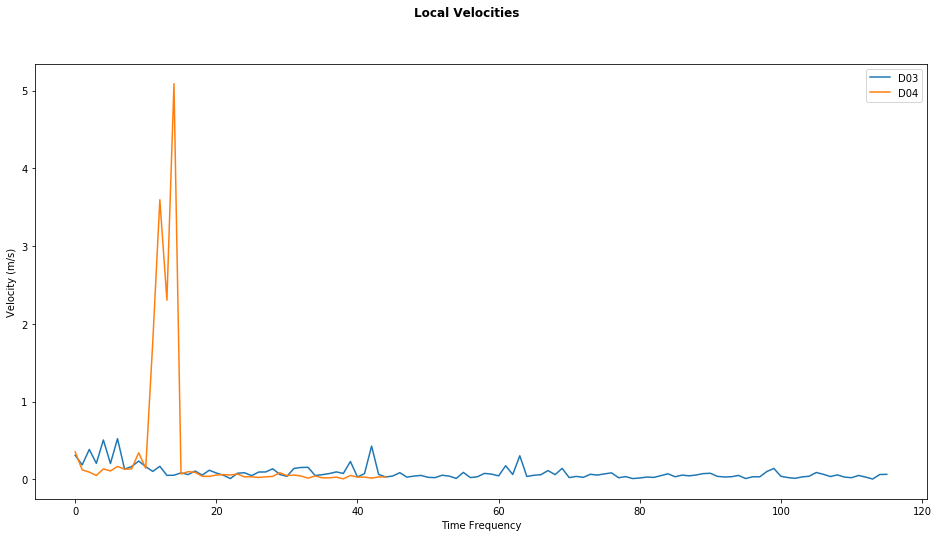

In [34]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def plot_local_velocities(currents_velocities, drifter_names):
  fig = plt.figure(figsize=(16,8))
  
  fig.suptitle("""Local Velocities\n\n""", fontweight ="bold") 
  for idx, curr in enumerate(currents_velocities):
    plt.plot(curr, label=drifter_names[idx])
    plt.ylabel('Velocity (m/s)')
    plt.xlabel('Time Frequency')
    plt.legend()
  fig.show()

plot_local_velocities(currents_velocities, drifter_names)

### Plotting GPS locations

In [35]:
import folium

# swan_coordinates = [-31.9976045, 115.8226236] # good coordinates for swan river test 1
swan_coordinates = [-33.9316144, 115.1822156]
swan_map = folium.Map(location=swan_coordinates, zoom_start=15) # init map over swan river

# using frequency defined at top of notebook
# Many points causes map to lag a great deal
def add_markers_to_map(map, drifter_list, drifter_names, with_radius=False):
    colour_list = ['blue', 'orange', 'gray', 'green', 'lightblue', 'lightgray', 'lightred', 'darkred', 'darkgreen',
        'purple', 'lightgreen', 'red', 'pink', 'beige', 'black', 'darkpurple', 'darkblue', 'white', 'cadetblue']
    for idx, drifter in enumerate(drifter_list):
        for ii in range(len(drifter.Longitude)):
            folium.Marker(
                location=[drifter.Latitude[ii], drifter.Longitude[ii]],
                popup=f"<stong>Pos: {ii} </stong>",
                icon=folium.Icon(icon="none", color=colour_list[idx]),
                tooltip=drifter_names[idx]).add_to(map)
            if with_radius:
                folium.Circle([drifter.Latitude[ii], drifter.Longitude[ii]],
                    color=colour_list[idx],
                    radius=2000).add_to(map)
        map.add_child(folium.LatLngPopup())
    return map

swan_map_w_markers = add_markers_to_map(swan_map, drifter_list, drifter_names, True)
swan_map_w_markers